Findings so far 

- Let's just stick with single point predictions. Sequence predictions tend to complicate things more.  
- Let's try noise augmentation and see how much it helps. We let the noise standard deviation to be 1% of the standard deviation of the entire dataset being augmented. 
- Before applying nosie augmentation, min-max scale the volume values 
- There is no need for relative positional encoding. Let's just go with the absolute positional encoding.  
- We try with N = 30. But we can possibly try N = 60, 90, 120 and max ensemble all these 4 models. Or we may use other ensemble methods like weighted averaging. Max ensemble is the simplest for now. 
- We have been running for 50 epochs, but maybe around 30 epochs is usually enough. 

In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
import tensorflow_addons as tfa
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow_probability import distributions as tfd
import seaborn as sns
from keras.utils.np_utils import to_categorical
import pywt

# Load Data

In [2]:
## season 2 dataframes 
train_x_2 = pd.read_csv('train_x_df.csv')
train_y_2 = pd.read_csv('train_y_df.csv') 
test_x_2 = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape

((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [3]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape

((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [4]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()

In [5]:
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()

In [6]:
full_df = np.concatenate([x_train, y_train], axis = 1) 
full_df.shape

(7661, 1500, 10)

In [7]:
price_data = full_df[:,:,[1,2,3,4]] 

volume_data = full_df[:,:,[5,6,7,8,9]] 

price_data.shape, volume_data.shape 

((7661, 1500, 4), (7661, 1500, 5))

In [8]:
# min max normalize volume features, as they vary a lot in scale 
for i in tqdm(range(volume_data.shape[0])):
    for j in range(volume_data.shape[2]): 
        min_val = np.min(volume_data[i,:,j]) 
        max_val = np.max(volume_data[i,:,j]) 
        volume_data[i,:,j] = (volume_data[i,:,j] - min_val) / (max_val - min_val)

100%|██████████| 7661/7661 [00:00<00:00, 8211.14it/s]


In [9]:
train_price, val_price, train_volume, val_volume = train_test_split(price_data, volume_data, test_size = 0.1, random_state = 42)

In [10]:
train_price.shape, val_price.shape, train_volume.shape, val_volume.shape

((6894, 1500, 4), (767, 1500, 4), (6894, 1500, 5), (767, 1500, 5))

# Data Augmentation

In [11]:
def price_noise_augmentation(arr): 
    std = np.std(arr)
    ret = np.zeros(shape=arr.shape)
    for i in tqdm(range(arr.shape[0])): 
        noise = np.random.normal(0, 0.01 * std, 751) 
        augmented = np.zeros((1500,4)) # open, high, low, close 
        for j in range(arr.shape[2]): 
            cA,cD = pywt.dwt(arr[i,:,j],'db2') 
            cD += noise 
            reconstructed = pywt.idwt(cA,cD,'db2') 
            augmented[:,j] = reconstructed 
        if augmented[1379,0] > 1: 
            diff = augmented[1379,0]-1
            augmented -= diff 
        elif augmented[1379,0] < 1: 
            diff = 1-augmented[1379,0] 
            augmented += diff 
        ret[i] = augmented 
    return ret 


def volume_noise_augmentation(arr): 
    std = np.std(arr)
    ret = np.zeros(shape=arr.shape) 
    for i in tqdm(range(arr.shape[0])): 
        noise = np.random.normal(0, 0.01*std, 751) 
        augmented = np.zeros((1500,5)) 
        for j in range(arr.shape[2]): 
            cA,cD = pywt.dwt(arr[i,:,j], 'db2') 
            cD += noise 
            reconstructed = pywt.idwt(cA,cD,'db2') 
            for l in range(len(reconstructed)): 
                reconstructed[l] = max(0, reconstructed[l])  
            augmented[:,j] = reconstructed
        ret[i] = augmented 
    return ret 

In [12]:
train_price_aug = price_noise_augmentation(train_price) 
train_vol_aug = volume_noise_augmentation(train_volume) 

train_price_aug.shape, train_vol_aug.shape

100%|██████████| 6894/6894 [00:30<00:00, 228.90it/s]


((6894, 1500, 4), (6894, 1500, 5))

In [13]:
train_price = np.concatenate([train_price, train_price_aug]) 
train_vol = np.concatenate([train_volume, train_vol_aug]) 

train_price.shape, train_vol.shape

((13788, 1500, 4), (13788, 1500, 5))

In [19]:
val_price.shape, val_volume.shape

((767, 1500, 4), (767, 1500, 5))

# Preprocess Data

In [20]:
N = 30
K = 120 
seq_len = 1500 
features_price = 4
features_volume = 5 

X_price = np.zeros(((seq_len-N-K)*train_price.shape[0], N, features_price))
X_volume = np.zeros(((seq_len-N-K)*train_price.shape[0], N, features_volume))
Y = np.zeros(((seq_len-N-K)*train_price.shape[0])) 

cnt = 0 
for i in tqdm(range(train_price.shape[0]), position = 0, leave = True): 
    j = 0 
    while j+N+K < seq_len: 
        X_price[cnt,:,:] = train_price[i, j:j+N, :] 
        X_volume[cnt,:,:] = train_vol[i, j:j+N, :] 
        Y[cnt] = train_price[i, j+N+K, 0] # get open prices as target 
        j += 1 
        cnt += 1 
        
        
X_price_val = np.zeros(((seq_len-N-K)*val_price.shape[0],N,features_price)) 
X_volume_val = np.zeros(((seq_len-N-K)*val_price.shape[0],N,features_volume)) 
Y_val = np.zeros(((seq_len-N-K)*val_price.shape[0]))

cnt = 0 
for i in tqdm(range(val_price.shape[0]), position = 0, leave = True): 
    j = 0 
    while j+N+K < seq_len: 
        X_price_val[cnt,:,:] = val_price[i, j:j+N, :] 
        X_volume_val[cnt,:,:] = val_volume[i, j:j+N, :] 
        Y_val[cnt] = val_price[i, j+N+K, 0] # get open prices as target 
        j += 1 
        cnt += 1 
        

X_price.shape, X_volume.shape, Y.shape, X_price_val.shape, X_volume_val.shape, Y_val.shape

100%|██████████| 767/767 [00:04<00:00, 170.31it/s]


((18613800, 30, 4),
 (18613800, 30, 5),
 (18613800,),
 (1035450, 30, 4),
 (1035450, 30, 5),
 (1035450,))

In [21]:
# for additional feature engineering 
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='glorot_uniform',
                                              trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='glorot_uniform',
                                           trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='glorot_uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [22]:
def transformer_block(inputs, node, drop_rate, activation): 
    attn_output = MultiHeadAttention(num_heads = 4, key_dim = node)(inputs, inputs) 
    attn_output = Dropout(drop_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    ffn_output = Dense(node, activation = activation)(out1)
    ffn_output = Dense(node)(ffn_output)
    ffn_output = Dropout(drop_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output) 
    return out2 

def transformer_model(inputs, node=64, activation='relu', drop_rate=0.2, num_layers=3): 
    time_embedding = Time2Vector(N)
    bn = BatchNormalization()(inputs)
    x = time_embedding(bn)
    x = Concatenate()([bn, x])
    x = Conv1D(node, 5, activation=activation, padding='same')(x)
    x = MaxPooling1D(3)(x) 
    x = Conv1D(node*2, 5, activation=activation, padding='same')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(drop_rate)(x)
    positions = tf.range(start=0, limit=x.shape[1], delta=1)
    positions = Embedding(input_dim = x.shape[1], output_dim = node*2)(positions) 
    x = x + positions 
    for i in range(num_layers): 
        x = transformer_block(x, node*2, drop_rate, activation) 
        x = BatchNormalization()(x) 
    return x

def build_model(node=64, activation='relu', drop_rate=0.2, num_layers=3, num_classes=10): 
    price_inputs = Input((N, features_price))
    volume_inputs = Input((N, features_volume)) 
    
    x_p = transformer_model(price_inputs) 
    x_v = transformer_model(volume_inputs)
    
    x = Concatenate()([x_p, x_v])
    x = Dense(x_p.shape[-1], activation = 'relu')(x) 
    x = BatchNormalization()(x) 
    
    x = GRU(64, return_sequences=False)(x)
    x = Dropout(drop_rate)(x) 

    x = Dense(1, activation = 'relu')(x) 
    model = Model(inputs=[price_inputs, volume_inputs], outputs=x) 
    model.compile(loss='mape',optimizer='adam',metrics=['mae','mse','mape'])
    return model


In [23]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30, 4)        16          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 30, 5)        20          input_2[0][0]                    
______________________________________________________________________________________________

In [24]:
model_path = 'transformer_point_prediction_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit([X_price, X_volume], 
                     Y, 
                     batch_size = 512, 
                     epochs = 50, 
                     callbacks = [learning_rate_reduction, checkpoint], 
                     validation_data = ([X_price_val, X_volume_val], Y_val))


Epoch 1/50
36356/36356 [==============================] - 1167s 28ms/step - loss: 2.3851 - mae: 0.0239 - mse: 0.0031 - mape: 2.3851 - val_loss: 1.0567 - val_mae: 0.0106 - val_mse: 2.9217e-04 - val_mape: 1.0567

Epoch 00001: val_loss improved from inf to 1.05666, saving model to transformer_point_prediction_epoch_001_val_1.057.h5
Epoch 2/50
36356/36356 [==============================] - 1003s 28ms/step - loss: 1.0004 - mae: 0.0100 - mse: 2.8796e-04 - mape: 1.0004 - val_loss: 0.9542 - val_mae: 0.0095 - val_mse: 2.5340e-04 - val_mape: 0.9542

Epoch 00002: val_loss improved from 1.05666 to 0.95420, saving model to transformer_point_prediction_epoch_002_val_0.954.h5
Epoch 3/50
36356/36356 [==============================] - 996s 27ms/step - loss: 0.9884 - mae: 0.0099 - mse: 2.7918e-04 - mape: 0.9884 - val_loss: 1.0587 - val_mae: 0.0106 - val_mse: 2.6766e-04 - val_mape: 1.0587

Epoch 00003: val_loss did not improve from 0.95420
Epoch 4/50
36356/36356 [==============================] - 1000s 2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 1010s 28ms/step - loss: 0.9793 - mae: 0.0098 - mse: 2.7268e-04 - mape: 0.9793 - val_loss: 0.9469 - val_mae: 0.0094 - val_mse: 2.5073e-04 - val_mape: 0.9469

Epoch 00005: val_loss improved from 0.95420 to 0.94692, saving model to transformer_point_prediction_epoch_005_val_0.947.h5
Epoch 6/50
 2863/36356 [=>............................] - ETA: 15:16 - loss: 0.9784 - mae: 0.0098 - mse: 2.7191e-04 - mape: 0.9784

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16340/36356 [============>.................] - ETA: 9:00 - loss: 0.9774 - mae: 0.0098 - mse: 2.7068e-04 - mape: 0.9774

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



29982/36356 [=======================>......] - ETA: 2:51 - loss: 0.9776 - mae: 0.0098 - mse: 2.7093e-04 - mape: 0.9776

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 6919/36356 [====>.........................] - ETA: 14:50 - loss: 0.9771 - mae: 0.0098 - mse: 2.7131e-04 - mape: 0.9771

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



25927/36356 [====================>.........] - ETA: 4:38 - loss: 0.9769 - mae: 0.0098 - mse: 2.6903e-04 - mape: 0.9769

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 995s 27ms/step - loss: 0.9770 - mae: 0.0098 - mse: 2.6888e-04 - mape: 0.9770 - val_loss: 0.9584 - val_mae: 0.0096 - val_mse: 2.4848e-04 - val_mape: 0.9584

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00008: val_loss did not improve from 0.94692
Epoch 9/50
 3784/36356 [==>...........................] - ETA: 14:29 - loss: 0.9717 - mae: 0.0097 - mse: 2.6438e-04 - mape: 0.9717

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17603/36356 [=============>................] - ETA: 8:20 - loss: 0.9710 - mae: 0.0097 - mse: 2.6346e-04 - mape: 0.9710

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



29960/36356 [=======================>......] - ETA: 2:50 - loss: 0.9705 - mae: 0.0097 - mse: 2.6317e-04 - mape: 0.9705

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 7991/36356 [=====>........................] - ETA: 12:36 - loss: 0.9691 - mae: 0.0097 - mse: 2.6227e-04 - mape: 0.9691

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22220/36356 [=================>............] - ETA: 6:17 - loss: 0.9683 - mae: 0.0097 - mse: 2.6246e-04 - mape: 0.9683

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36252/36356 [============================>.] - ETA: 2s - loss: 0.9679 - mae: 0.0097 - mse: 2.6246e-04 - mape: 0.9679

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



13909/36356 [==========>...................] - ETA: 10:07 - loss: 0.9672 - mae: 0.0097 - mse: 2.6159e-04 - mape: 0.9672

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27723/36356 [=====================>........] - ETA: 3:53 - loss: 0.9672 - mae: 0.0097 - mse: 2.6216e-04 - mape: 0.9672

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 1003s 28ms/step - loss: 0.9672 - mae: 0.0097 - mse: 2.6240e-04 - mape: 0.9672 - val_loss: 0.9456 - val_mae: 0.0095 - val_mse: 2.4584e-04 - val_mape: 0.9456

Epoch 00011: val_loss improved from 0.94692 to 0.94556, saving model to transformer_point_prediction_epoch_011_val_0.946.h5
Epoch 12/50
 5867/36356 [===>..........................] - ETA: 13:37 - loss: 0.9653 - mae: 0.0097 - mse: 2.6175e-04 - mape: 0.9653

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27508/36356 [=====================>........] - ETA: 3:56 - loss: 0.9655 - mae: 0.0097 - mse: 2.6179e-04 - mape: 0.9655

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 993s 27ms/step - loss: 0.9655 - mae: 0.0097 - mse: 2.6171e-04 - mape: 0.9655 - val_loss: 0.9409 - val_mae: 0.0094 - val_mse: 2.4609e-04 - val_mape: 0.9409

Epoch 00012: val_loss improved from 0.94556 to 0.94092, saving model to transformer_point_prediction_epoch_012_val_0.941.h5
Epoch 13/50
 3982/36356 [==>...........................] - ETA: 14:24 - loss: 0.9626 - mae: 0.0096 - mse: 2.5988e-04 - mape: 0.9626

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17515/36356 [=============>................] - ETA: 8:22 - loss: 0.9642 - mae: 0.0096 - mse: 2.6097e-04 - mape: 0.9642

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



31041/36356 [========================>.....] - ETA: 2:21 - loss: 0.9644 - mae: 0.0097 - mse: 2.6121e-04 - mape: 0.9644

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8751/36356 [======>.......................] - ETA: 12:43 - loss: 0.9655 - mae: 0.0097 - mse: 2.6285e-04 - mape: 0.9655

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 1033s 28ms/step - loss: 0.9650 - mae: 0.0097 - mse: 2.6247e-04 - mape: 0.9650 - val_loss: 0.9522 - val_mae: 0.0095 - val_mse: 2.5131e-04 - val_mape: 0.9522

Epoch 00014: val_loss did not improve from 0.94092
Epoch 15/50
16826/36356 [============>.................] - ETA: 8:58 - loss: 0.9658 - mae: 0.0097 - mse: 2.6330e-04 - mape: 0.9658

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



30813/36356 [========================>.....] - ETA: 2:30 - loss: 0.9657 - mae: 0.0097 - mse: 2.6291e-04 - mape: 0.9657

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8437/36356 [=====>........................] - ETA: 12:26 - loss: 0.9623 - mae: 0.0096 - mse: 2.6045e-04 - mape: 0.9623

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22385/36356 [=================>............] - ETA: 6:12 - loss: 0.9618 - mae: 0.0096 - mse: 2.5973e-04 - mape: 0.9618

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 995s 27ms/step - loss: 0.9614 - mae: 0.0096 - mse: 2.5953e-04 - mape: 0.9614 - val_loss: 0.9467 - val_mae: 0.0095 - val_mse: 2.4254e-04 - val_mape: 0.9467

Epoch 00016: val_loss did not improve from 0.94092
Epoch 17/50
  319/36356 [..............................] - ETA: 15:50 - loss: 0.9583 - mae: 0.0096 - mse: 2.5740e-04 - mape: 0.9583

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



25743/36356 [====================>.........] - ETA: 4:44 - loss: 0.9592 - mae: 0.0096 - mse: 2.5831e-04 - mape: 0.9592

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 994s 27ms/step - loss: 0.9593 - mae: 0.0096 - mse: 2.5835e-04 - mape: 0.9593 - val_loss: 0.9415 - val_mae: 0.0094 - val_mse: 2.4333e-04 - val_mape: 0.9415

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00018: val_loss did not improve from 0.94092
Epoch 19/50
 3565/36356 [=>............................] - ETA: 14:49 - loss: 0.9577 - mae: 0.0096 - mse: 2.6143e-04 - mape: 0.9577

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17650/36356 [=============>................] - ETA: 8:30 - loss: 0.9574 - mae: 0.0096 - mse: 2.5906e-04 - mape: 0.9574

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



31483/36356 [========================>.....] - ETA: 2:11 - loss: 0.9575 - mae: 0.0096 - mse: 2.5881e-04 - mape: 0.9575

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 9166/36356 [======>.......................] - ETA: 12:04 - loss: 0.9582 - mae: 0.0096 - mse: 2.5887e-04 - mape: 0.9582

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23218/36356 [==================>...........] - ETA: 5:50 - loss: 0.9580 - mae: 0.0096 - mse: 2.5839e-04 - mape: 0.9580

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 992s 27ms/step - loss: 0.9580 - mae: 0.0096 - mse: 2.5841e-04 - mape: 0.9580 - val_loss: 0.9446 - val_mae: 0.0094 - val_mse: 2.4309e-04 - val_mape: 0.9446

Epoch 00020: val_loss did not improve from 0.94092
Epoch 21/50
  449/36356 [..............................] - ETA: 15:49 - loss: 0.9585 - mae: 0.0096 - mse: 2.5865e-04 - mape: 0.9585

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14350/36356 [==========>...................] - ETA: 9:44 - loss: 0.9582 - mae: 0.0096 - mse: 2.5843e-04 - mape: 0.9582

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



28786/36356 [======================>.......] - ETA: 3:23 - loss: 0.9580 - mae: 0.0096 - mse: 2.5832e-04 - mape: 0.9580

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 6015/36356 [===>..........................] - ETA: 13:42 - loss: 0.9575 - mae: 0.0096 - mse: 2.5913e-04 - mape: 0.9575

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19364/36356 [==============>...............] - ETA: 7:34 - loss: 0.9566 - mae: 0.0096 - mse: 2.5786e-04 - mape: 0.9566

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



32769/36356 [==========================>...] - ETA: 1:35 - loss: 0.9565 - mae: 0.0096 - mse: 2.5761e-04 - mape: 0.9565

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 9765/36356 [=======>......................] - ETA: 11:48 - loss: 0.9564 - mae: 0.0096 - mse: 2.5852e-04 - mape: 0.9564

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23429/36356 [==================>...........] - ETA: 5:44 - loss: 0.9563 - mae: 0.0096 - mse: 2.5798e-04 - mape: 0.9563

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 990s 27ms/step - loss: 0.9564 - mae: 0.0096 - mse: 2.5781e-04 - mape: 0.9564 - val_loss: 0.9418 - val_mae: 0.0094 - val_mse: 2.4553e-04 - val_mape: 0.9418

Epoch 00023: val_loss did not improve from 0.94091
Epoch 24/50
  769/36356 [..............................] - ETA: 15:50 - loss: 0.9546 - mae: 0.0096 - mse: 2.5444e-04 - mape: 0.9546

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14621/36356 [===========>..................] - ETA: 9:40 - loss: 0.9558 - mae: 0.0096 - mse: 2.5632e-04 - mape: 0.9558

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



28623/36356 [======================>.......] - ETA: 3:26 - loss: 0.9559 - mae: 0.0096 - mse: 2.5650e-04 - mape: 0.9559

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 995s 27ms/step - loss: 0.9559 - mae: 0.0096 - mse: 2.5659e-04 - mape: 0.9559 - val_loss: 0.9401 - val_mae: 0.0094 - val_mse: 2.4232e-04 - val_mape: 0.9401

Epoch 00024: val_loss improved from 0.94091 to 0.94007, saving model to transformer_point_prediction_epoch_024_val_0.940.h5
Epoch 25/50
 5653/36356 [===>..........................] - ETA: 13:40 - loss: 0.9566 - mae: 0.0096 - mse: 2.5695e-04 - mape: 0.9566

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17081/36356 [=============>................] - ETA: 8:34 - loss: 0.9561 - mae: 0.0096 - mse: 2.5718e-04 - mape: 0.9561

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



31558/36356 [=========================>....] - ETA: 2:07 - loss: 0.9559 - mae: 0.0096 - mse: 2.5714e-04 - mape: 0.9559

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 9045/36356 [======>.......................] - ETA: 12:08 - loss: 0.9545 - mae: 0.0096 - mse: 2.5813e-04 - mape: 0.9545

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22697/36356 [=================>............] - ETA: 6:03 - loss: 0.9550 - mae: 0.0096 - mse: 2.5736e-04 - mape: 0.9550

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35935/36356 [============================>.] - ETA: 11s - loss: 0.9553 - mae: 0.0096 - mse: 2.5724e-04 - mape: 0.9553

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14042/36356 [==========>...................] - ETA: 9:52 - loss: 0.9548 - mae: 0.0096 - mse: 2.5724e-04 - mape: 0.9548

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27772/36356 [=====================>........] - ETA: 3:48 - loss: 0.9553 - mae: 0.0096 - mse: 2.5700e-04 - mape: 0.9553

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 989s 27ms/step - loss: 0.9554 - mae: 0.0096 - mse: 2.5695e-04 - mape: 0.9554 - val_loss: 0.9410 - val_mae: 0.0094 - val_mse: 2.4332e-04 - val_mape: 0.9410

Epoch 00027: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00027: val_loss did not improve from 0.94007
Epoch 28/50
 5563/36356 [===>..........................] - ETA: 13:35 - loss: 0.9541 - mae: 0.0095 - mse: 2.5571e-04 - mape: 0.9541

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19894/36356 [===============>..............] - ETA: 7:17 - loss: 0.9547 - mae: 0.0096 - mse: 2.5620e-04 - mape: 0.9547

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



33159/36356 [==========================>...] - ETA: 1:24 - loss: 0.9551 - mae: 0.0096 - mse: 2.5650e-04 - mape: 0.9551

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10960/36356 [========>.....................] - ETA: 12:07 - loss: 0.9553 - mae: 0.0096 - mse: 2.5613e-04 - mape: 0.9553

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



25378/36356 [===================>..........] - ETA: 5:12 - loss: 0.9553 - mae: 0.0096 - mse: 2.5646e-04 - mape: 0.9553

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 1035s 28ms/step - loss: 0.9553 - mae: 0.0096 - mse: 2.5653e-04 - mape: 0.9553 - val_loss: 0.9406 - val_mae: 0.0094 - val_mse: 2.4261e-04 - val_mape: 0.9406

Epoch 00029: val_loss did not improve from 0.94007
Epoch 30/50
 3602/36356 [=>............................] - ETA: 14:40 - loss: 0.9520 - mae: 0.0095 - mse: 2.5388e-04 - mape: 0.9520

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



18026/36356 [=============>................] - ETA: 8:10 - loss: 0.9534 - mae: 0.0095 - mse: 2.5512e-04 - mape: 0.9534

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



32215/36356 [=========================>....] - ETA: 1:51 - loss: 0.9540 - mae: 0.0095 - mse: 2.5556e-04 - mape: 0.9540

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 9923/36356 [=======>......................] - ETA: 11:43 - loss: 0.9546 - mae: 0.0096 - mse: 2.5630e-04 - mape: 0.9546

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23792/36356 [==================>...........] - ETA: 5:35 - loss: 0.9548 - mae: 0.0096 - mse: 2.5628e-04 - mape: 0.9548

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



33251/36356 [==========================>...] - ETA: 1:22 - loss: 0.9549 - mae: 0.0096 - mse: 2.5627e-04 - mape: 0.9549

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 997s 27ms/step - loss: 0.9549 - mae: 0.0096 - mse: 2.5627e-04 - mape: 0.9549 - val_loss: 0.9417 - val_mae: 0.0094 - val_mse: 2.4351e-04 - val_mape: 0.9417

Epoch 00031: val_loss did not improve from 0.94007
Epoch 32/50
 1741/36356 [>.............................] - ETA: 15:19 - loss: 0.9513 - mae: 0.0095 - mse: 2.5407e-04 - mape: 0.9513

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11007/36356 [========>.....................] - ETA: 11:16 - loss: 0.9544 - mae: 0.0096 - mse: 2.5674e-04 - mape: 0.9544

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15801/36356 [============>.................] - ETA: 9:08 - loss: 0.9546 - mae: 0.0096 - mse: 2.5675e-04 - mape: 0.9546

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



25042/36356 [===================>..........] - ETA: 5:01 - loss: 0.9547 - mae: 0.0096 - mse: 2.5666e-04 - mape: 0.9547

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



29987/36356 [=======================>......] - ETA: 2:49 - loss: 0.9547 - mae: 0.0096 - mse: 2.5661e-04 - mape: 0.9547

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 994s 27ms/step - loss: 0.9547 - mae: 0.0096 - mse: 2.5654e-04 - mape: 0.9547 - val_loss: 0.9409 - val_mae: 0.0094 - val_mse: 2.4364e-04 - val_mape: 0.9409

Epoch 00032: val_loss did not improve from 0.94007
Epoch 33/50
 2981/36356 [=>............................] - ETA: 14:48 - loss: 0.9536 - mae: 0.0095 - mse: 2.5684e-04 - mape: 0.9536

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 7723/36356 [=====>........................] - ETA: 12:43 - loss: 0.9542 - mae: 0.0095 - mse: 2.5674e-04 - mape: 0.9542

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17258/36356 [=============>................] - ETA: 8:27 - loss: 0.9547 - mae: 0.0096 - mse: 2.5663e-04 - mape: 0.9547

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22179/36356 [=================>............] - ETA: 6:17 - loss: 0.9548 - mae: 0.0096 - mse: 2.5665e-04 - mape: 0.9548

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



34653/36356 [===========================>..] - ETA: 45s - loss: 0.9548 - mae: 0.0096 - mse: 2.5662e-04 - mape: 0.9548

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11599/36356 [========>.....................] - ETA: 11:00 - loss: 0.9559 - mae: 0.0096 - mse: 2.5735e-04 - mape: 0.9559

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



25729/36356 [====================>.........] - ETA: 4:43 - loss: 0.9553 - mae: 0.0096 - mse: 2.5684e-04 - mape: 0.9553

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 989s 27ms/step - loss: 0.9551 - mae: 0.0096 - mse: 2.5666e-04 - mape: 0.9551 - val_loss: 0.9408 - val_mae: 0.0094 - val_mse: 2.4315e-04 - val_mape: 0.9408

Epoch 00034: val_loss did not improve from 0.94007
Epoch 35/50
36356/36356 [==============================] - 1004s 28ms/step - loss: 0.9548 - mae: 0.0096 - mse: 2.5673e-04 - mape: 0.9548 - val_loss: 0.9409 - val_mae: 0.0094 - val_mse: 2.4317e-04 - val_mape: 0.9409

Epoch 00035: val_loss did not improve from 0.94007
Epoch 36/50
36356/36356 [==============================] - 1019s 28ms/step - loss: 0.9546 - mae: 0.0096 - mse: 2.5611e-04 - mape: 0.9546 - val_loss: 0.9417 - val_mae: 0.0094 - val_mse: 2.4373e-04 - val_mape: 0.9417

Epoch 00036: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00036: val_loss did not improve from 0.94007
Epoch 37/50
12901/36356 [=========>....................] - ETA: 10:29 - loss: 0.9549 - mae: 0.0096 - mse: 2.5630e-04 - mape: 0.9549

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



26674/36356 [=====================>........] - ETA: 4:18 - loss: 0.9547 - mae: 0.0096 - mse: 2.5631e-04 - mape: 0.9547

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 991s 27ms/step - loss: 0.9546 - mae: 0.0096 - mse: 2.5631e-04 - mape: 0.9546 - val_loss: 0.9411 - val_mae: 0.0094 - val_mse: 2.4327e-04 - val_mape: 0.9411

Epoch 00037: val_loss did not improve from 0.94007
Epoch 38/50
 3971/36356 [==>...........................] - ETA: 14:26 - loss: 0.9556 - mae: 0.0096 - mse: 2.5632e-04 - mape: 0.9556

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17157/36356 [=============>................] - ETA: 8:31 - loss: 0.9553 - mae: 0.0096 - mse: 2.5647e-04 - mape: 0.9553

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



31196/36356 [========================>.....] - ETA: 2:17 - loss: 0.9549 - mae: 0.0096 - mse: 2.5623e-04 - mape: 0.9549

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8485/36356 [======>.......................] - ETA: 12:24 - loss: 0.9544 - mae: 0.0095 - mse: 2.5579e-04 - mape: 0.9544

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22634/36356 [=================>............] - ETA: 6:06 - loss: 0.9544 - mae: 0.0095 - mse: 2.5590e-04 - mape: 0.9544

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35456/36356 [============================>.] - ETA: 24s - loss: 0.9545 - mae: 0.0096 - mse: 2.5607e-04 - mape: 0.9545

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12965/36356 [=========>....................] - ETA: 10:24 - loss: 0.9545 - mae: 0.0096 - mse: 2.5585e-04 - mape: 0.9545

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27027/36356 [=====================>........] - ETA: 4:08 - loss: 0.9545 - mae: 0.0095 - mse: 2.5602e-04 - mape: 0.9545

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 989s 27ms/step - loss: 0.9544 - mae: 0.0095 - mse: 2.5601e-04 - mape: 0.9544 - val_loss: 0.9407 - val_mae: 0.0094 - val_mse: 2.4382e-04 - val_mape: 0.9407

Epoch 00040: val_loss did not improve from 0.94007
Epoch 41/50
 4353/36356 [==>...........................] - ETA: 14:09 - loss: 0.9550 - mae: 0.0096 - mse: 2.5585e-04 - mape: 0.9550

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17981/36356 [=============>................] - ETA: 8:10 - loss: 0.9545 - mae: 0.0095 - mse: 2.5579e-04 - mape: 0.9545

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



30275/36356 [=======================>......] - ETA: 2:42 - loss: 0.9545 - mae: 0.0095 - mse: 2.5589e-04 - mape: 0.9545

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 7784/36356 [=====>........................] - ETA: 12:43 - loss: 0.9564 - mae: 0.0096 - mse: 2.5885e-04 - mape: 0.9564

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21528/36356 [================>.............] - ETA: 6:34 - loss: 0.9554 - mae: 0.0096 - mse: 2.5749e-04 - mape: 0.9554

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35384/36356 [============================>.] - ETA: 25s - loss: 0.9550 - mae: 0.0096 - mse: 2.5705e-04 - mape: 0.9550

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12713/36356 [=========>....................] - ETA: 10:30 - loss: 0.9542 - mae: 0.0095 - mse: 2.5559e-04 - mape: 0.9542

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



26444/36356 [====================>.........] - ETA: 4:24 - loss: 0.9544 - mae: 0.0095 - mse: 2.5594e-04 - mape: 0.9544

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 997s 27ms/step - loss: 0.9545 - mae: 0.0095 - mse: 2.5603e-04 - mape: 0.9545 - val_loss: 0.9411 - val_mae: 0.0094 - val_mse: 2.4323e-04 - val_mape: 0.9411

Epoch 00043: val_loss did not improve from 0.94007
Epoch 44/50
 3833/36356 [==>...........................] - ETA: 15:02 - loss: 0.9529 - mae: 0.0095 - mse: 2.5580e-04 - mape: 0.9529

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17456/36356 [=============>................] - ETA: 8:41 - loss: 0.9535 - mae: 0.0095 - mse: 2.5601e-04 - mape: 0.9535

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



31217/36356 [========================>.....] - ETA: 2:19 - loss: 0.9539 - mae: 0.0095 - mse: 2.5602e-04 - mape: 0.9539

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8605/36356 [======>.......................] - ETA: 12:15 - loss: 0.9540 - mae: 0.0095 - mse: 2.5549e-04 - mape: 0.9540

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22450/36356 [=================>............] - ETA: 6:09 - loss: 0.9543 - mae: 0.0095 - mse: 2.5597e-04 - mape: 0.9543

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36160/36356 [============================>.] - ETA: 5s - loss: 0.9544 - mae: 0.0096 - mse: 2.5613e-04 - mape: 0.9544

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



13627/36356 [==========>...................] - ETA: 10:08 - loss: 0.9541 - mae: 0.0095 - mse: 2.5569e-04 - mape: 0.9541

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27587/36356 [=====================>........] - ETA: 3:54 - loss: 0.9542 - mae: 0.0095 - mse: 2.5582e-04 - mape: 0.9542

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 995s 27ms/step - loss: 0.9543 - mae: 0.0095 - mse: 2.5593e-04 - mape: 0.9543 - val_loss: 0.9409 - val_mae: 0.0094 - val_mse: 2.4387e-04 - val_mape: 0.9409

Epoch 00046: val_loss did not improve from 0.94007
Epoch 47/50
 3367/36356 [=>............................] - ETA: 14:41 - loss: 0.9556 - mae: 0.0096 - mse: 2.5626e-04 - mape: 0.9556

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17365/36356 [=============>................] - ETA: 8:28 - loss: 0.9547 - mae: 0.0096 - mse: 2.5611e-04 - mape: 0.9547

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



31256/36356 [========================>.....] - ETA: 2:16 - loss: 0.9545 - mae: 0.0096 - mse: 2.5592e-04 - mape: 0.9545

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8779/36356 [======>.......................] - ETA: 12:19 - loss: 0.9528 - mae: 0.0095 - mse: 2.5520e-04 - mape: 0.9528

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22379/36356 [=================>............] - ETA: 6:13 - loss: 0.9537 - mae: 0.0095 - mse: 2.5583e-04 - mape: 0.9537

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36078/36356 [============================>.] - ETA: 7s - loss: 0.9539 - mae: 0.0095 - mse: 2.5593e-04 - mape: 0.9539

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



13727/36356 [==========>...................] - ETA: 10:04 - loss: 0.9545 - mae: 0.0095 - mse: 2.5638e-04 - mape: 0.9545

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36356/36356 [==============================] - 992s 27ms/step - loss: 0.9545 - mae: 0.0095 - mse: 2.5639e-04 - mape: 0.9545 - val_loss: 0.9413 - val_mae: 0.0094 - val_mse: 2.4431e-04 - val_mape: 0.9413

Epoch 00049: val_loss did not improve from 0.94007
Epoch 50/50
36356/36356 [==============================] - 992s 27ms/step - loss: 0.9547 - mae: 0.0096 - mse: 2.5658e-04 - mape: 0.9547 - val_loss: 0.9406 - val_mae: 0.0094 - val_mse: 2.4347e-04 - val_mape: 0.9406

Epoch 00050: val_loss did not improve from 0.94007


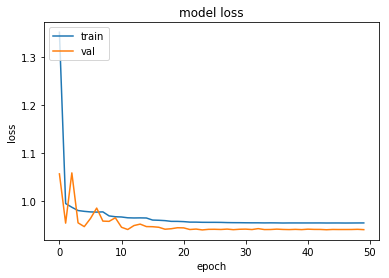

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show() 

# Make Prediction

In [26]:
best_model = load_model('transformer_point_prediction_epoch_024_val_0.940.h5', custom_objects = {'Time2Vector':Time2Vector}) 
best_model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30, 4)        16          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 30, 5)        20          input_2[0][0]                    
______________________________________________________________________________________________

In [27]:
X_test_price = [] 
X_test_volume = []

for j in tqdm(range(x_test.shape[0]), position = 0, leave = True): 
    for i in range(seq_len-K-N-120, seq_len-K-N):
        X_test_price.append(x_test[j, i:i+N, [1,2,3,4]])  
        X_test_volume.append(x_test[j, i:i+N, [5,6,7,8,9]])

X_test_price = np.asarray(X_test_price) 
X_test_volume = np.asarray(X_test_volume) 

X_test_price = X_test_price.reshape((-1,N,features_price)) 
X_test_volume = X_test_volume.reshape((-1,N,features_volume))

X_test_price.shape, X_test_volume.shape

100%|██████████| 535/535 [00:00<00:00, 915.81it/s] 


((64200, 30, 4), (64200, 30, 5))

In [28]:
predicted = best_model.predict([X_test_price, X_test_volume]) 
predicted = predicted.reshape((-1,120)) 
predicted.shape

(535, 120)

In [29]:
x_test_open = x_test[:,:,1] 

## Adjust predicted prices to be connected with the buy price 
for i in tqdm(range(predicted.shape[0]), position = 0, leave = True):
    buy_price = x_test_open[i,-1] 
    if predicted[i,0] > buy_price:
        diff = predicted[i,0] - buy_price 
        predicted[i,:] -= diff 
    elif predicted[i,0] < buy_price:  
        diff = buy_price - predicted[i,0] 
        predicted[i,:] += diff 

100%|██████████| 535/535 [00:00<00:00, 121967.21it/s]


In [30]:
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_open[i,-1] 
    cnt = 0 
    for j in range(120): 
        if predicted[i,j] >= buy_price:    
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('transformers_data_aug_N_30_point_prediction.csv',index=False)


100%|██████████| 535/535 [00:00<00:00, 3891.95it/s]


In [31]:
# Check submission file 
submission 

,sample_id,buy_quantity,sell_time
0,7661,0.950000,104
1,7662,0.950000,38
2,7663,1.000000,87
3,7664,0.166667,15
4,7665,0.650000,119
...,...,...,...
530,8191,0.083333,9
531,8192,0.033333,100
532,8193,0.991667,86
533,8194,0.025000,1


# Visualize Plots

In [33]:
X_train_samples_price = []  
X_train_samples_volume = [] 
for i in tqdm(range(50)):  
    for j in range(seq_len-N-K-120, seq_len-N-K):  
        X_train_samples_price.append(price_data[i,j:j+N,:]) 
        X_train_samples_volume.append(volume_data[i,j:j+N,:]) 

X_train_samples_price = np.asarray(X_train_samples_price) 
X_train_samples_volume = np.asarray(X_train_samples_volume) 

X_train_samples_price.shape, X_train_samples_volume.shape 

100%|██████████| 50/50 [00:00<00:00, 5776.80it/s]


((6000, 30, 4), (6000, 30, 5))

In [34]:
pred_train = best_model.predict([X_train_samples_price, X_train_samples_volume]) 
pred_train = pred_train.reshape((-1,120)) 
pred_train.shape 

(50, 120)

In [42]:
x_test_open = price_data[:,:,0] 

## Adjust predicted prices to be connected with the buy price 
for i in tqdm(range(pred_train.shape[0]), position = 0, leave = True):
    buy_price = x_test_open[i,-1] 
    if pred_train[i,0] > buy_price:
        diff = predicted[i,0] - buy_price 
        pred_train[i,:] -= diff 
    elif pred_train[i,0] < buy_price:  
        diff = buy_price - pred_train[i,0] 
        pred_train[i,:] += diff  

100%|██████████| 50/50 [00:00<00:00, 85388.93it/s]


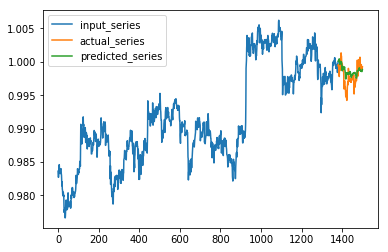

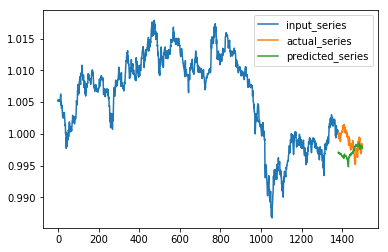

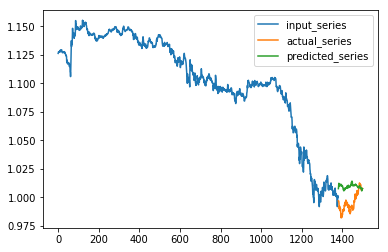

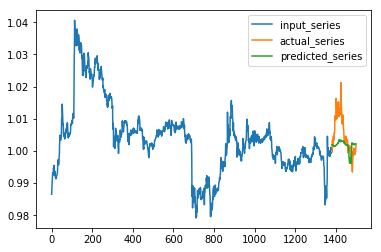

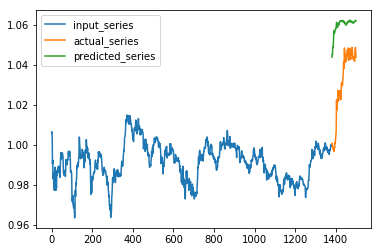

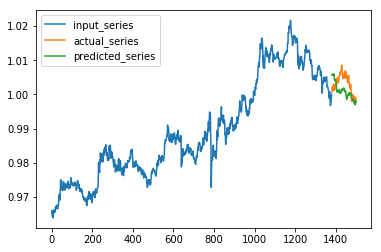

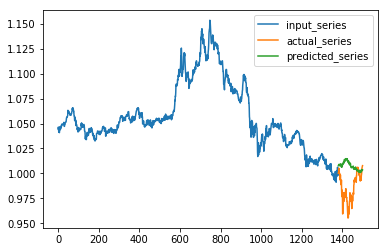

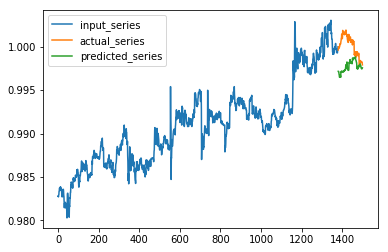

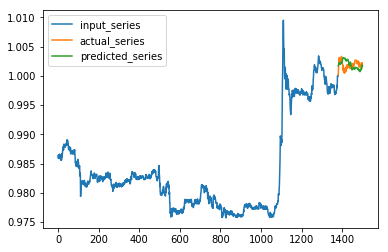

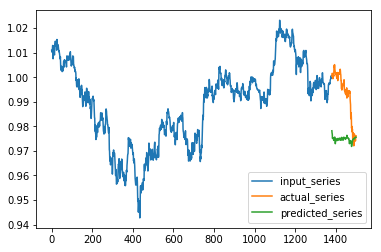

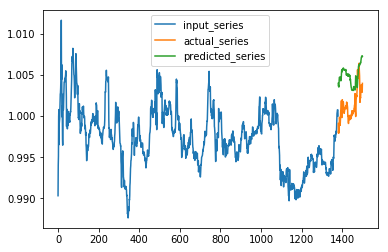

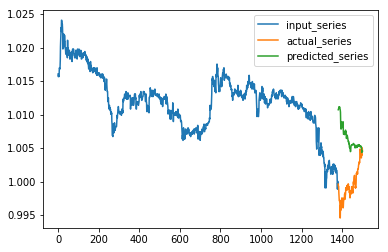

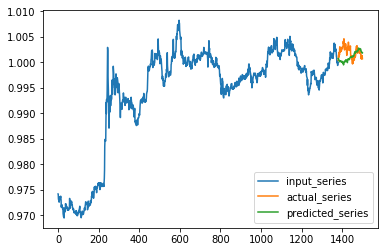

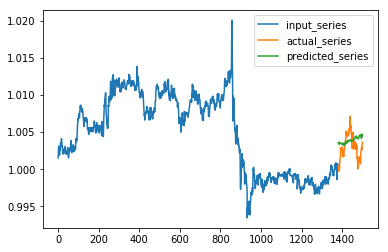

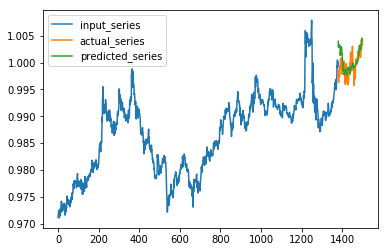

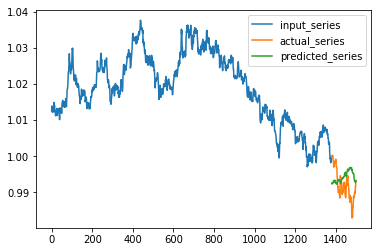

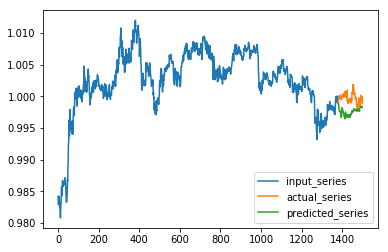

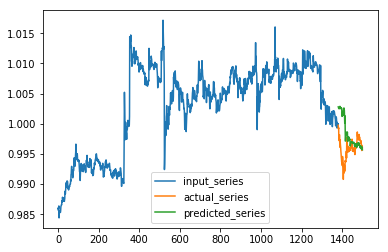

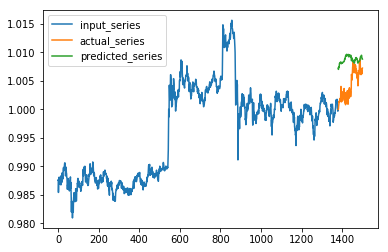

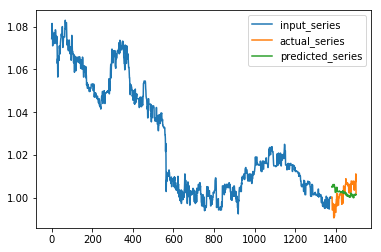

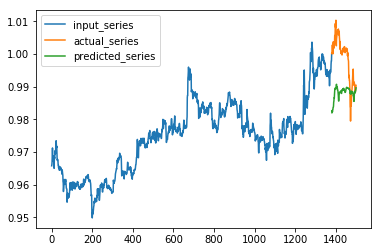

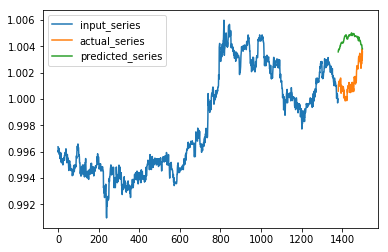

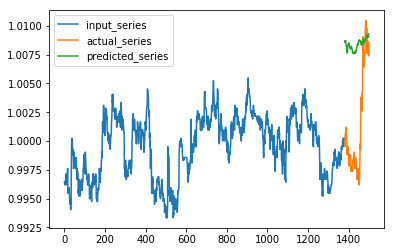

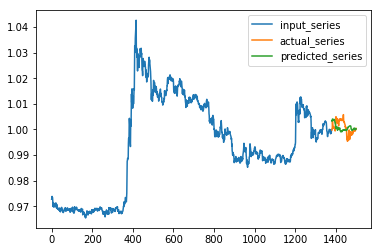

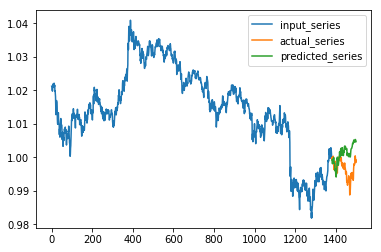

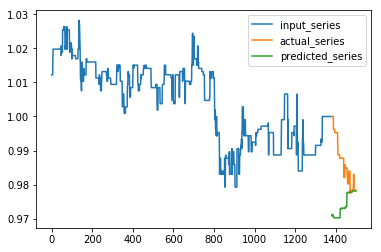

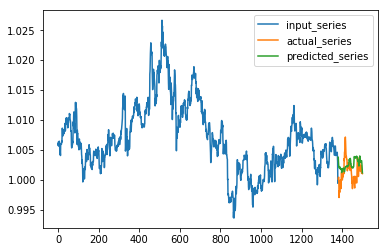

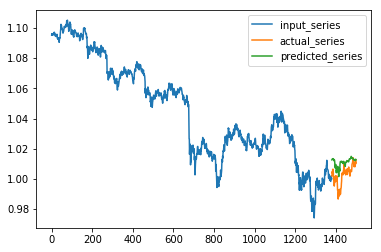

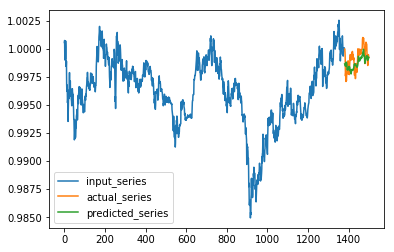

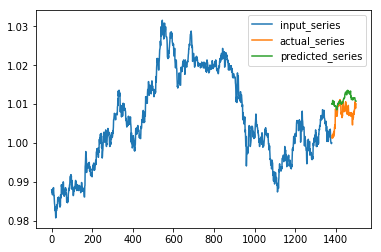

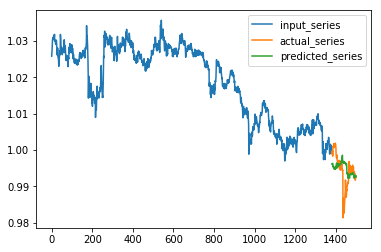

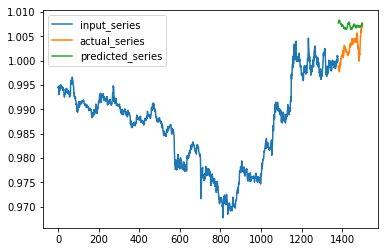

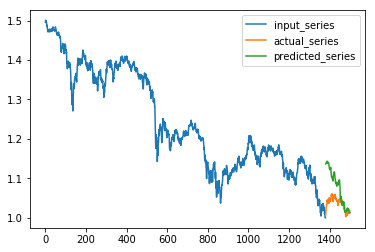

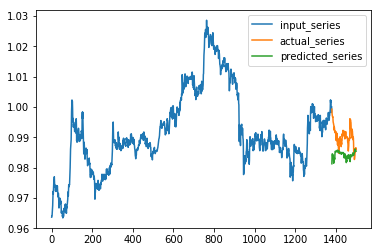

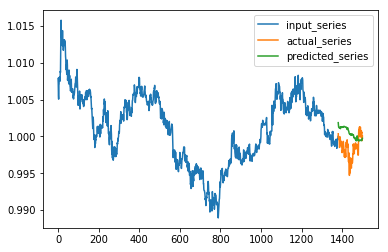

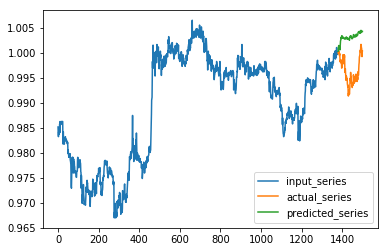

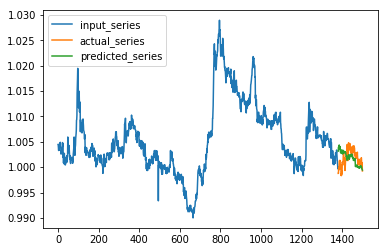

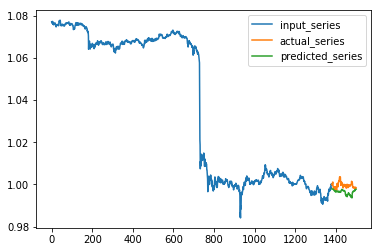

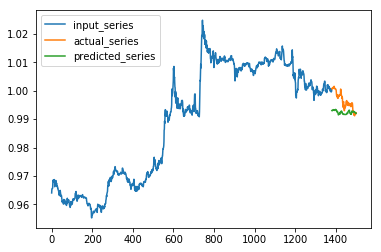

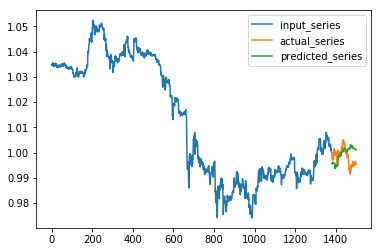

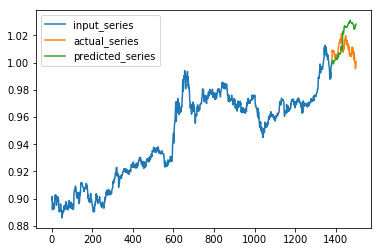

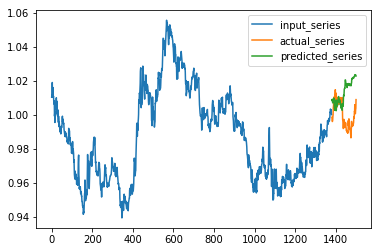

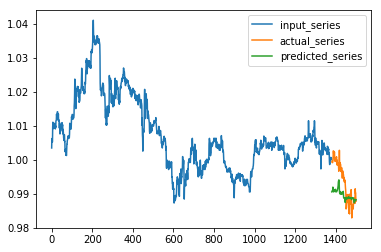

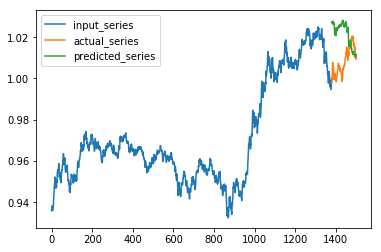

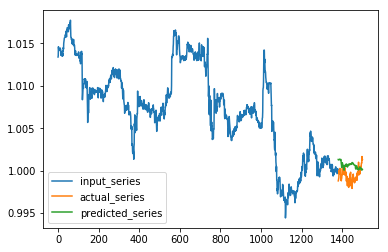

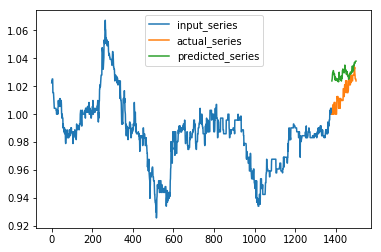

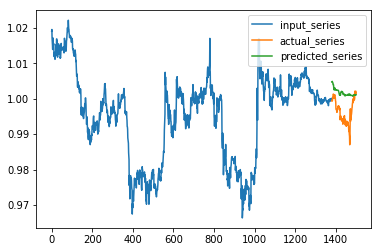

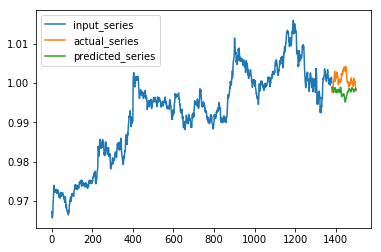

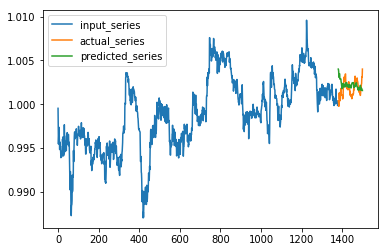

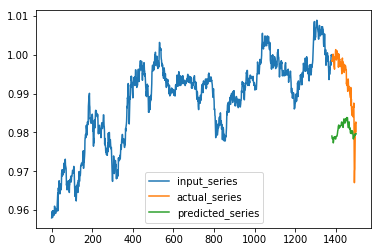

In [43]:
for i in range(50): 
    plt.plot()
    plot_series(price_data[i,:1380,0], price_data[i,1380:,0], pred_train[i,:]) 
    plt.show() 

# Ensemble

In [44]:
df1 = pd.read_csv('max_ensemble_just_testing.csv')

In [45]:
df2 = pd.read_csv('transformers_data_aug_N_30_point_prediction.csv')

In [46]:
bq=[]
st=[]

df1_bq = df1['buy_quantity'] 
df1_st = df1['sell_time'] 
df2_bq = df2['buy_quantity'] 
df2_st = df2['sell_time'] 

for i in tqdm(range(df1_bq.shape[0])): 
    if df1_bq[i] > df2_bq[i]: 
        bq.append(df1_bq[i]) 
        st.append(df1_st[i]) 
    else: 
        bq.append(df2_bq[i]) 
        st.append(df2_st[i]) 

100%|██████████| 535/535 [00:00<00:00, 58239.10it/s]


In [47]:
submission.iloc[:,1] = bq 
submission.iloc[:,2] = st 


In [49]:
submission.to_csv('max_3.csv',index=False)